In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import pylab
f

ModuleNotFoundError: No module named 'utils'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print('Model can run on :{}'.format(device))

Model can run on :cuda


In [5]:
a = torch.randint(0,10,(10000,))
b = torch.randint(0,10,(10000,))
c = torch.randint(0,10,(1000,))
d = torch.randint(0,10,(1000,))

In [6]:
e = a+b
f = c+d

In [7]:
X_train = torch.stack((a,b),1).float()
Y_train = e
X_test = torch.stack((c,d),1).float()
Y_test = f

In [8]:
class my_data():
    def __init__(self,X,Y):
        self.x = X
        self.y = Y
#         self.y = F.one_hot(self.y,)

    def __getitem__(self,idx):
        return self.x[idx,:],self.y[idx]

    def __len__(self):
        return len(self.x)

In [9]:
train_data = my_data(X_train,Y_train)
test_data = my_data(X_test,Y_test)

In [10]:
count = 0
for p in range(0,10000):
    if (Y_train[p].item() == count) & (count <= 20) :
        train_data.y[p]
        Y_train[p]
        print ("+++++++++++")
        print (count)
        count += 1

tensor(0)

tensor(0)

+++++++++++
0


tensor(1)

tensor(1)

+++++++++++
1


tensor(2)

tensor(2)

+++++++++++
2


tensor(3)

tensor(3)

+++++++++++
3


tensor(4)

tensor(4)

+++++++++++
4


tensor(5)

tensor(5)

+++++++++++
5


tensor(6)

tensor(6)

+++++++++++
6


tensor(7)

tensor(7)

+++++++++++
7


tensor(8)

tensor(8)

+++++++++++
8


tensor(9)

tensor(9)

+++++++++++
9


tensor(10)

tensor(10)

+++++++++++
10


tensor(11)

tensor(11)

+++++++++++
11


tensor(12)

tensor(12)

+++++++++++
12


tensor(13)

tensor(13)

+++++++++++
13


tensor(14)

tensor(14)

+++++++++++
14


tensor(15)

tensor(15)

+++++++++++
15


tensor(16)

tensor(16)

+++++++++++
16


tensor(17)

tensor(17)

+++++++++++
17


tensor(18)

tensor(18)

+++++++++++
18


In [11]:
cuda = torch.cuda.is_available()

In [12]:
cuda

True

In [13]:
dataloader_args = dict(shuffle=True, batch_size=16, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=1)

In [14]:
train_loader = DataLoader(train_data,**dataloader_args)
test_loader = DataLoader(test_data,**dataloader_args)

In [15]:
class MNISTadder(nn.Module):
    def __init__(self,input_dim = 2,output_dim = 1):
        super(MNISTadder,self).__init__()
        
        self.layer1 = nn.Linear(in_features=input_dim,out_features=8)
        self.layer2 = nn.Linear(in_features=8,out_features=16)
        self.layer3 = nn.Linear(in_features=16,out_features=32)
        self.layer4 = nn.Linear(in_features=32,out_features=19)
    
    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        return x 

In [40]:
(2*8 + 8) + (8*16 + 16) + (16*32 + 32) + (32*19 + 19)

1339

In [44]:
500 * 2*6 * 4

24000

In [43]:
1339 / 1024

1.3076171875

In [16]:
model = MNISTadder().to('cuda')

In [17]:
summary(model,(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              24
            Linear-2                   [-1, 16]             144
            Linear-3                   [-1, 32]             544
            Linear-4                   [-1, 19]             627
Total params: 1,339
Trainable params: 1,339
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def accuracy(model, ds):
    # assumes model.eval()
    n_correct = 0; n_wrong = 0
    # using loader avoids resize() issues
    ldr = DataLoader(ds, batch_size=1,shuffle=False)
    for _, (data,target) in enumerate(ldr):
        data,target = data.to('cuda'),target.to('cuda')
        X = data
        Y = target
        with torch.no_grad():
            oupt = model(X)  # probs form    
        if torch.argmax(Y) == torch.argmax(oupt):
            n_correct += 1
        else:
            n_wrong += 1
    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    return acc

def train(model, device, train_loader, optimizer, epoch,loss_fun):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data,target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
#         target = target.to(torch.float32)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = loss_fun(y_pred,target)
#         loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} ')

def test(model,test_data):
    acc = accuracy(model,test_data)
    test_acc.append(acc)
    print (f'Test data Accuracy :{acc*100}%')
        
# def test(model, device, test_loader,loss_fun):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data,target in test_loader:
#             data, target = data.to(device), target.to(device)
            
#             output = model(data)
            
#             # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             acc = accuracy(pred,target)
            
#     print('\nTest set: Accuracy:{}'.format(acc)
#     test_acc.append(acc)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = MNISTadder().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.09, momentum=0.9)
# loss_func = torch.nn.MSELoss()
loss_func = nn.CrossEntropyLoss()
# loss_func2 = nn.CrossEntropyLoss()
EPOCHS = 50
for epoch in range(EPOCHS):
    print("\n EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,loss_func)
    test(model, test_data)

  0%|          | 0/625 [00:00<?, ?it/s]

cuda

 EPOCH: 0


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 1


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 2


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 3


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 4


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 5


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 6


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 7


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 8


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 9


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 10


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 11


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 12


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 13


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 14


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 15


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 16


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 17


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 18


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 19


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 20


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 21


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 22


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 23


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 24


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 25


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 26


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 27


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 28


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 29


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 30


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 31


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 32


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 33


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 34


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 35


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 36


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 37


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 38


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 39


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 40


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 41


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 42


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 43


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 44


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 45


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 46


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 47


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 48


  0%|          | 0/625 [00:00<?, ?it/s]

Test data Accuracy :1.0%

 EPOCH: 49


Loss=2.8971283435821533 Batch_id=624 : 100%|██████████| 625/625 [00:02<00:00, 225.02it/s]


Test data Accuracy :1.0%


In [20]:
model.train()
pbar = tqdm(train_loader)
correct = 0
processed = 0
for batch_idx, (data,target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    
    
    break
    

MNISTadder(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=19, bias=True)
)

  0%|          | 0/625 [00:00<?, ?it/s]


In [21]:
pred = model(data)

In [22]:
target.long()

tensor([ 9,  1,  8, 10,  4,  6,  9,  3,  9,  3,  5,  5, 10, 10,  5,  8],
       device='cuda:0')

In [23]:
target

tensor([ 9,  1,  8, 10,  4,  6,  9,  3,  9,  3,  5,  5, 10, 10,  5,  8],
       device='cuda:0')

In [24]:
loss_func(pred,target)

tensor(2.7392, device='cuda:0', grad_fn=<NllLossBackward>)

In [25]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [26]:
input
target

tensor([[ 0.1629, -0.2480,  1.1818,  1.8425, -1.4741],
        [-1.0327, -0.2342,  0.6834,  1.9487, -0.6355],
        [-2.6688, -0.8213, -0.9976, -0.2528,  1.1162]], requires_grad=True)

tensor([4, 0, 0])

In [27]:
target

tensor([4, 0, 0])

In [28]:
target

tensor([4, 0, 0])

In [29]:
import matplotlib.pyplot as plt

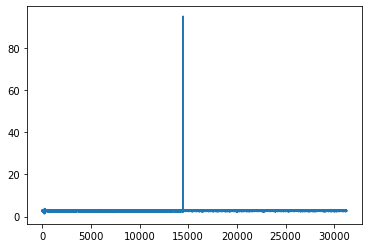

In [30]:
plt.plot(train_losses)

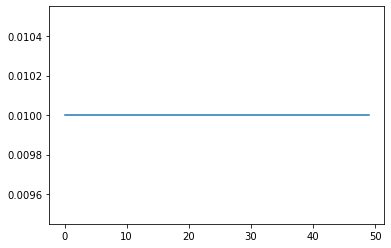

In [31]:
plt.plot(test_acc)

In [32]:
p = model(torch.tensor([1.,6.]).to('cuda'))

In [33]:
p

tensor([-6.8105, -0.3407,  0.0341,  0.1265,  0.4165,  0.4437,  0.5620,  0.9188,
         1.1616,  1.0979,  1.2663,  1.0688,  1.0696,  0.3626,  0.5873,  0.1375,
        -0.0830, -0.4668, -1.1642], device='cuda:0', grad_fn=<AddBackward0>)

In [34]:
for batch_idx, (data,target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
#     target = target.to(torch.float32)
    break

In [35]:
p = model(data)

In [36]:
data.T

tensor([[8., 1., 2., 0., 5., 1., 4., 9., 7., 1., 4., 1., 7., 3., 3., 2.],
        [1., 5., 7., 5., 2., 0., 8., 0., 2., 2., 9., 2., 2., 2., 1., 3.]],
       device='cuda:0')

In [37]:
target.argmax(dim = 1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
p.argmax(dim = 1)


In [ ]:
count = 0
for m in range(0,10000):
    
    if (Y_train[m].item() == 8) & (X_train[m][0].item() == 6) & (X_train[m][1].item() == 2) :
        print (m)
        train_data.y[m]
        X_train[m]
        Y_train[m]
        print ("+++++++++++")
        print (count)
        count += 1
        break